In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
### Import file 1
gajhq_filepath = r"C:\Users\TyHow\MinersAI Dropbox\Science\Geo Data\Saudi Arabia\Jabal Al Hasir\GA  GAJHQ   Jabal al Hasir Data.xlsx"
gajhq_raw_data = pd.read_excel(gajhq_filepath, sheet_name="Jabal al Hasir Database")
gajhq_raw_data.head(5)

,Jabal al Hasir Quadrangle Database,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58
0,Analytical Results of a Reconnaissance Geochem...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Samples Collected:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Data Reported : 05/03/2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,Elements,SiO2,Al2O3,Fe2O3,TiO2,CaO,MgO,Na2O,...,Tb,Th,Tm,U,V,W,Y,Yb,Zn,Zr


In [3]:
### Set custom headers, drop header rows, and reset index
gajhq_columns_part1 = gajhq_raw_data.iloc[6, 0:3].tolist()
gajhq_columns_part2 = gajhq_raw_data.iloc[4, 3:].tolist()

gajhq_columns = gajhq_columns_part1 + gajhq_columns_part2

print("Number of columns in part1:", len(gajhq_columns_part1))
print('columns1 =', gajhq_columns_part1)
print("Number of columns in part2:", len(gajhq_columns_part2))
print('columns2 =', gajhq_columns_part2)
print("Total columns in data:", gajhq_raw_data.shape[1])

gajhq_data = gajhq_raw_data.copy()
gajhq_data.columns = gajhq_columns
gajhq_data.columns = gajhq_data.columns.str.strip()
gajhq_data = gajhq_data.iloc[7:].reset_index(drop=True)

Number of columns in part1: 3
columns1 = ['Sample No.', 'LONG', 'LAT']
Number of columns in part2: 56
columns2 = ['SiO2', 'Al2O3', 'Fe2O3', 'TiO2', 'CaO', 'MgO', 'Na2O', 'K2O', 'MnO', 'SO3', 'P2O5', 'LOI ', 'Au', 'Ag ', 'As ', 'Ba ', 'Be ', 'Bi ', 'Cd ', 'Ce ', 'Co ', 'Cr ', 'Cu ', 'Dy ', 'Er ', 'Eu', 'Ga', 'Gd', 'Ge ', 'Hf ', 'Ho', 'La ', 'Li ', 'Lu ', 'Mo ', 'Nb ', 'Nd ', 'Ni ', 'Pb ', 'Pr ', 'Sb ', 'Sc ', 'Sm ', 'Sn ', 'Sr ', 'Ta', 'Tb ', 'Th', 'Tm ', 'U ', 'V ', 'W', 'Y ', 'Yb ', 'Zn', 'Zr ']
Total columns in data: 59


In [4]:
### Clean data

# Isolate DLs
gajhq_numerical_row = pd.to_numeric(gajhq_raw_data.iloc[5], errors="coerce").fillna(
    0
) + pd.to_numeric(gajhq_raw_data.iloc[6], errors="coerce").fillna(0)

gajhq_DLs = gajhq_numerical_row.to_numpy()
# print("GAJHQ DLs:", gajhq_DLs)

# Replace "<" values with 1/3 of the DL value
for col_index in range(3, gajhq_data.shape[1]):
    dl_value = gajhq_DLs[col_index]

    gajhq_data.iloc[:, col_index] = gajhq_data.iloc[:, col_index].replace(
        r"<.*", 0.333333 * dl_value, regex=True
    )
    # print(f'replaced <DL values in column {col_index} with {dl_value * 0.333333}')


# Identify columns labeled as '%'
gajhq_labels = gajhq_raw_data.iloc[5].astype(str).fillna("") + gajhq_raw_data.iloc[
    6
].astype(str).fillna("")

gajhq_labels = gajhq_labels.str.strip()

percent_col_indices = gajhq_labels[gajhq_labels.str.contains("%", na=False)].index
percent_numerical_indices = [
    gajhq_raw_data.columns.get_loc(col) for col in percent_col_indices
]

# Convert % to ppm
gajhq_data.iloc[:, percent_numerical_indices] = (
    gajhq_data.iloc[:, percent_numerical_indices] * 10000
)

#Drop empty columns
gajhq_data = gajhq_data.loc[:, gajhq_data.nunique() > 1]

C:\Users\TyHow\AppData\Local\Temp\ipykernel_21224\3014912270.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gajhq_data.iloc[:, col_index] = gajhq_data.iloc[:, col_index].replace(


Statistics:

Average correlation: 0.1421273344648178
Max correlation: 1.0
Min correlation: -0.809665348392544


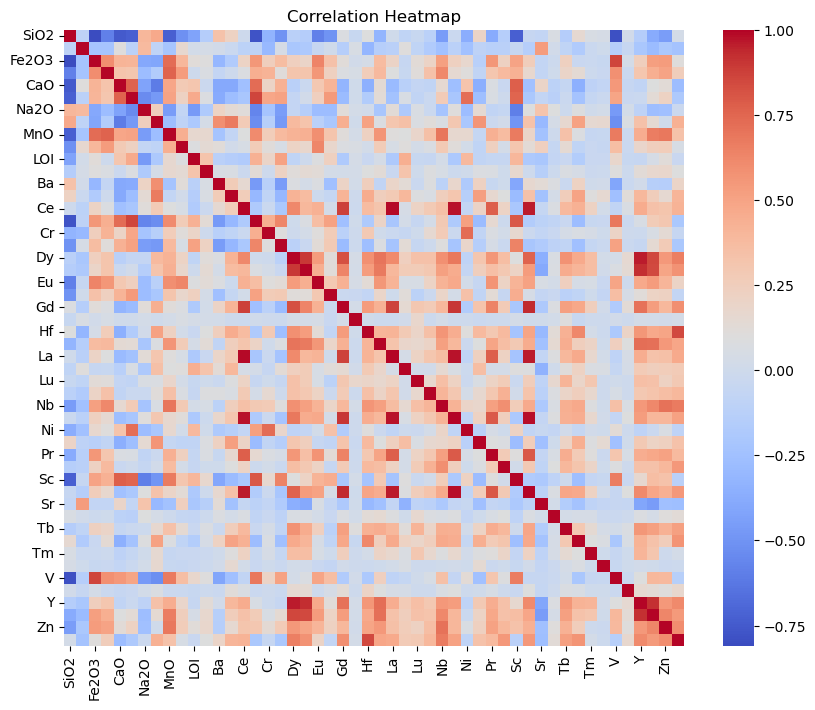

In [5]:
# Corr plot
gajhq_corr = gajhq_data.iloc[:, 3:].corr()

print("Statistics:\n")
print("Average correlation:", gajhq_corr.stack().mean())
print("Max correlation:", gajhq_corr.stack().max())
print("Min correlation:", gajhq_corr.stack().min())

plt.figure(figsize=(10, 8))
sns.heatmap(gajhq_corr, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [6]:
### PCA

# Omit non-numeric columns
gajhq_data_pca = gajhq_data.copy()
gajhq_data_pca = gajhq_data_pca.iloc[:, 3:]

scaler = StandardScaler()
gajhq_data_scaled = scaler.fit_transform(gajhq_data_pca)

# Perform PCA
pca = PCA()
gajhq_pca_results = pca.fit_transform(gajhq_data_scaled)

# Explained variance
gajhq_explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", gajhq_explained_variance)

# PCA results as a DataFrame (optional)
pca_df = pd.DataFrame(
    gajhq_pca_results, columns=[f"PC{i+1}" for i in range(len(gajhq_explained_variance))]
)

Explained Variance Ratios: [2.48262651e-01 1.91879277e-01 6.60186240e-02 4.55426843e-02
 4.34414150e-02 3.87052032e-02 3.10216869e-02 2.96292535e-02
 2.51472424e-02 2.35917276e-02 2.21380583e-02 2.00774167e-02
 1.83522090e-02 1.81658513e-02 1.66455574e-02 1.52481177e-02
 1.29155573e-02 1.23019164e-02 1.14370445e-02 1.08537617e-02
 9.73920256e-03 8.35061874e-03 8.05484820e-03 7.77778775e-03
 7.26314230e-03 7.12709313e-03 6.46095498e-03 5.95539832e-03
 5.44479573e-03 4.22811801e-03 3.85666641e-03 3.22894188e-03
 2.93178569e-03 2.73329829e-03 2.57924696e-03 2.24626272e-03
 1.67277781e-03 1.65010166e-03 1.64087268e-03 1.46422045e-03
 1.04336272e-03 8.82611427e-04 7.39554902e-04 4.97318148e-04
 3.13990055e-04 2.44727329e-04 2.27750475e-04 1.54169234e-04
 1.14691722e-04 4.33924472e-07]
